<a href="https://colab.research.google.com/github/jvjruiz/Colab-notebooks/blob/master/Happy_Customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background and Exploratory Data Analysis:

ACME is one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. During the COVID-19 pandemic, we are facing several different challenges and everyday we are trying to address these challenges.

At ACME we thrive for making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

In [ ]:
# import necessary packages
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
from sklearn import svm


import itertools
from matplotlib import pyplot as plt

Data Description:

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers <br> 
X1 = my order was delivered on time<br>
X2 = contents of my order was as I expected<br>
X3 = I ordered everything I wanted to order<br>
X4 = I paid a good price for my order<br>
X5 = I am satisfied with my courier<br>
X6 = the app makes ordering easy for me<br>

In [ ]:
# initialize random_state for everything
random_state = 42

# load the data from google drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/ml_stuff/ACME-HappinessSurvey2020.csv'
df = pd.read_csv(path)
df.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [ ]:
# rename columns to make them more friendly
df = df.rename(columns={'Y':'happy','X1':'on_time', 'X2':'as_expected', 'X3': 'everything_ordered', 'X4':'good_price', 'X5':'satisfied_courier', 'X6':'app_easy'})
df.head()

,happy,on_time,as_expected,everything_ordered,good_price,satisfied_courier,app_easy
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [ ]:
df.dtypes

happy                 int64
on_time               int64
as_expected           int64
everything_ordered    int64
good_price            int64
satisfied_courier     int64
app_easy              int64
dtype: object

Before throwing the data into any models, we should do some basic exploratory data analysis to get a better understanding, and also to see if we need to do any pre-processing on the data.

In [ ]:
# check if any values are null or empty, we if any are empty we have to do do some pre-processing
df.isnull().sum()

happy                 0
on_time               0
as_expected           0
everything_ordered    0
good_price            0
satisfied_courier     0
app_easy              0
dtype: int64

Looks like there are no missing values, next we should check if the classes are balanced. If they aren't we would have to do some pre-processing to make the classes more balanced so the model can learn with less bias.

Below are some graphs on the data. It looks like the classes are balanced enough, and the means and standard deviations are generally close together.

Looking at the graph below, it looks like the classes are balanced enough, so we don't have to do anything further in that aspect.

In [ ]:
# some stats on the features
df.describe()

,happy,on_time,as_expected,everything_ordered,good_price,satisfied_courier,app_easy
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Text(0.5, 1.0, 'Class Distributions')

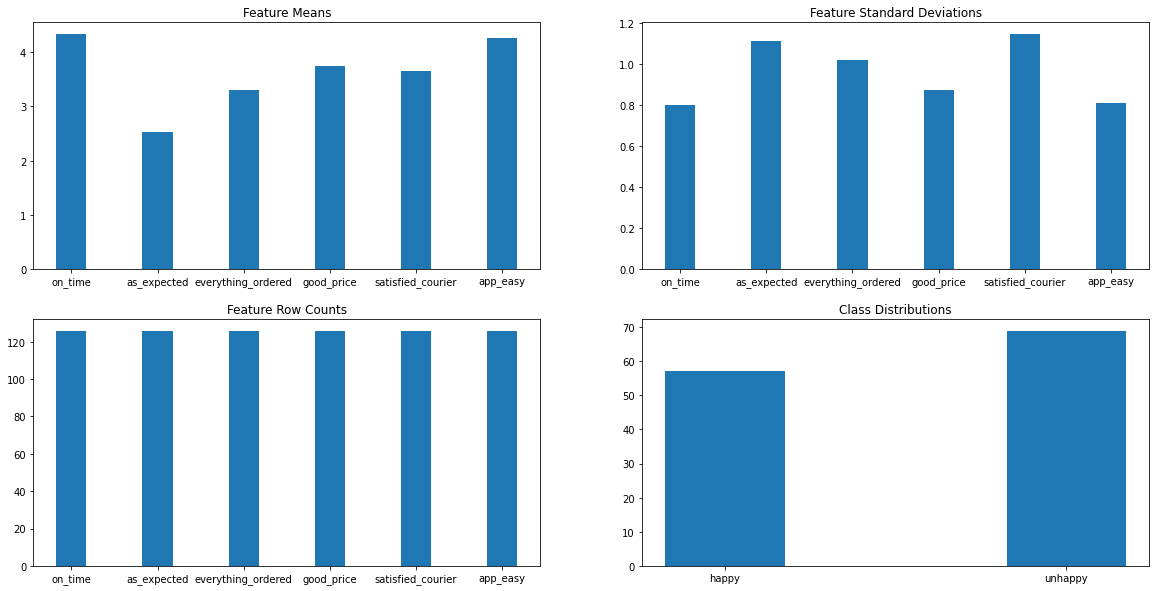

In [ ]:
# check distribution between classes
classes = ['happy','unhappy']
unique, class_counts = np.unique(df['happy'], return_counts=True)
working_df = df.drop('happy', axis=1)
means = working_df.describe(include='all').loc['mean']
stds = working_df.describe(include='all').loc['std']
counts = working_df.describe(include='all').loc['count']

labels = means.keys()

x = working_df.columns
width = 0.35  # the width of the bars


fig, ax = plt.subplots(2, 2, figsize=(20,10))

# display feature means
ax[0][0].bar(x, means, width)
ax[0][0].set_xticks(x)
ax[0][0].set_title('Feature Means')

# display standard deviations
ax[0][1].bar(x, stds, width)
ax[0][1].set_xticks(x)
ax[0][1].set_title('Feature Standard Deviations')

# display counts per feature
ax[1][0].bar(x, counts, width)
ax[1][0].set_xticks(x)
ax[1][0].set_title('Feature Row Counts')

# display class distribution
ax[1][1].bar(unique, class_counts, width)
ax[1][1].set_xticks(np.arange(2))
ax[1][1].set_xticklabels(classes)
ax[1][1].set_title('Class Distributions')



101 samples in training set
13 samples in test set
12 samples in validation set


Text(0.5, 1.0, 'Test Class Distributions')

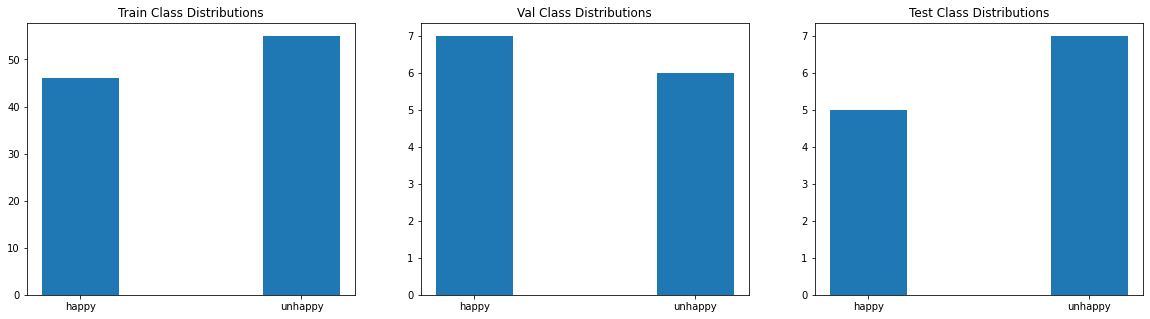

In [ ]:
# split dataset into training, validation, and test sets
X = df.drop('happy', axis=1)
y = df['happy']

# assign a validation set and save for model validation at the end after model selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=random_state)

# stratify remaining data into train and test sets
# stratifying data ensures that the datasets are balanced as possible
sss = StratifiedShuffleSplit(n_splits=1, test_size=.1, random_state=random_state)

for train_index, test_index in sss.split(X_train, y_train):
  X_train, X_val = X.loc[train_index], X.loc[test_index]
  y_train, y_val = y.loc[train_index], y.loc[test_index]

print("{} samples in training set".format(len(X_train)))
print("{} samples in test set".format(len(X_test)))
print("{} samples in validation set".format(len(X_val)))

train_unique, train_class_counts = np.unique(y_train, return_counts=True)
test_unique, test_class_counts = np.unique(y_test, return_counts=True)
val_unique, val_class_counts = np.unique(y_val, return_counts=True)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# display train class distribution
ax1.bar(train_unique, train_class_counts, width)
ax1.set_xticks(np.arange(2))
ax1.set_xticklabels(classes)
ax1.set_title('Train Class Distributions')

# display val class distribution
ax2.bar(test_unique, test_class_counts, width)
ax2.set_xticks(np.arange(2))
ax2.set_xticklabels(classes)
ax2.set_title('Val Class Distributions')

# display test class distribution
ax3.bar(val_unique, val_class_counts, width)
ax3.set_xticks(np.arange(2))
ax3.set_xticklabels(classes)
ax3.set_title('Test Class Distributions')

# Model Fitting and Selection


First we set up a helper function to allow for grid search of hyperparameters on whatever classifier we throw in.

Using the Holdout grid search methodology, we are able to many different combinations of hyperparameters on our models, while saving the best performing one for further validation using our validation set.

For evaluation we are using F1-scores as shown by the equation below:

![Equation for calculating F1 Score, Precision, and Recall.](https://miro.medium.com/max/534/1*EXa-_699fntpUoRjZeqAFQ.jpeg)

Two metrics used to calculate F1 scores are precision and recall. 

As shown above, precision is calcuated by taking the total amount of true positives, items classified correctly, divided by sum of the total amount of true positives and false positives, or items that were incorrectly labeled positive or in this case happy.

Recall is calculated by taking the total number of true positives divided by the sum of the total amount of true positives and False Negatives, in this case customers that were misclassified as being unhappy.


In [ ]:
def holdout_grid_search(clf, X_train, y_train, X_test, y_test, hyperparams, fixed_hyperparams={}, verbose=True):
    '''
    Conduct hyperparameter grid search on hold out validation set. Use holdout validation.
    Hyperparameters are input as a dictionary mapping each hyperparameter name to the
    range of values they should iterate over. Use the cindex function as your evaluation
    function.

    Input:
        clf: sklearn classifier
        X_train_hp (dataframe): dataframe for training set input variables
        y_train_hp (dataframe): dataframe for training set targets
        X_val_hp (dataframe): dataframe for validation set input variables
        y_val_hp (dataframe): dataframe for validation set targets
        hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                            names to range of values for grid search
        fixed_hyperparams (dict): dictionary of fixed hyperparameters that
                                  are not included in the grid search

    Output:
        best_estimator (sklearn classifier): fitted sklearn classifier with best performance on
                                             validation set
        best_hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                                 names to values in best_estimator
    '''
    
    best_estimator = None
    best_hyperparams = {}
    
    # hold best running score
    best_score = 0.0

    # get list of param values
    lists = hyperparams.values()
    
    # get all param combinations
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)


    # iterate through param combinations
    for i, params in enumerate(param_combinations, 1):

        # fill param dict with params
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
            
        # create estimator with specified params
        estimator = clf(**param_dict, **fixed_hyperparams)

        # fit estimator
        estimator.fit(X_train, y_train)
        
        # score the test set
        y_preds = estimator.predict(X_test)
        f_score = f1_score(y_test, y_preds)


        # if new high score, update high score, best estimator
        # and best params 
        if f_score >= best_score:
                if (verbose):
                  print(f'New Best Score: {f_score}\n')
                  print("{}\n".format(param_dict))
                best_score = f_score
                best_estimator = estimator
                best_hyperparams = param_dict

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_estimator, best_hyperparams

## Logistic Regression Classifier

First we will try using a simple logistic regression classifier to find a baseline level model.

Logistic regression is commonly used as a binary classification algorithm, but can be expanded for multiple classes. 

What is important here is the algorithm will provide a probability on which class the item belong's to, or in this case whether or not a customer is happy. After calculating the probabilities, the model returns the class with the higher probability score.

In [ ]:
def logistic_regression_grid_search(X_train, y_train, X_test, y_test, verbose=True):

    hyperparams = {
        # Inverse Regularization Strength
        'C': [0.001, 0.01, 0.1, 1.0, 10.0],

        # determine class weights for classifier, default is None
        # balanced automatically adjusts weights
        'class_weight': [None, 'balanced'],

        'solver': ['liblinear', 'lbfgs']
    }

    
    fixed_hyperparams = {
        'random_state': 42,
    }
    
    logr = LogisticRegression

    best_logr, best_hyperparams = holdout_grid_search(logr, X_train, y_train,
                                                    X_test, y_test, hyperparams,
                                                    fixed_hyperparams, verbose)

    print(f"Best hyperparameters:\n{best_hyperparams}")

    # score the train and test sets
    y_train_preds = best_logr.predict(X_train)
    f_score_train_best = f1_score(y_train, y_train_preds)
    print(f"Train Score: {f_score_train_best}")

    y_test_preds = best_logr.predict(X_test)
    f_score_test_best = f1_score(y_test, y_test_preds)
    print(f"Test Score: {f_score_test_best}")
    
    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_logr, best_hyperparams, f_score_test_best

In [ ]:
best_logr, best_hyperparams, best_logr_score = logistic_regression_grid_search(X_train, y_train, X_val, y_val)

New Best Score: 0.7368421052631579

{'C': 0.001, 'class_weight': None, 'solver': 'liblinear'}

New Best Score: 0.7368421052631579

{'C': 0.001, 'class_weight': None, 'solver': 'lbfgs'}

New Best Score: 0.7368421052631579

{'C': 0.001, 'class_weight': 'balanced', 'solver': 'liblinear'}

New Best Score: 0.7368421052631579

{'C': 0.01, 'class_weight': None, 'solver': 'liblinear'}

Best hyperparameters:
{'C': 0.01, 'class_weight': None, 'solver': 'liblinear', 'random_state': 42}
Train Score: 0.7142857142857143
Test Score: 0.7368421052631579


It looks like the best performing logistic regression model is only providing a F1 Score of .73. Let's see if we can use more complicated models to get better performance.

## Support Vector Machine's (SVM)

SVMs are a set of algorithms that are useful for classification, regression, and outlier detection. 

The SVM algorithm we will be testing here is SVC (Support Vector Classification).

In [ ]:
def SVC_grid_search(X_train, y_train, X_test, y_test, verbose=True):

    hyperparams = {
        # Inverse Regularization Strength
        'C': [0.001, 0.01, 0.1, 1.0, 10.0],

        # kernel to be used in algorithm
        'kernel': {'linear', 'poly', 'rbf', 'sigmoid'}
    }

    
    fixed_hyperparams = {
        'random_state': random_state,
    }
    
    svc = svm.SVC

    best_svc, best_hyperparams = holdout_grid_search(svc, X_train, y_train,
                                                    X_test, y_test, hyperparams,
                                                    fixed_hyperparams, verbose)

    print(f"Best hyperparameters:\n{best_hyperparams}")

    # score the train and test sets
    y_train_preds = best_svc.predict(X_train)
    f_score_train_best = f1_score(y_train, y_train_preds)
    print(f"Train Score: {f_score_train_best}")

    y_test_preds = best_svc.predict(X_test)
    f_score_test_best = f1_score(y_test, y_test_preds)
    print(f"Test Score: {f_score_test_best}")
    
    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_svc, best_hyperparams, f_score_test_best

In [ ]:
best_svc, best_hyperparams, best_svc_score = SVC_grid_search(X_train, y_train, X_val, y_val)

New Best Score: 0.7368421052631579

{'C': 0.001, 'kernel': 'sigmoid'}

New Best Score: 0.7368421052631579

{'C': 0.001, 'kernel': 'linear'}

New Best Score: 0.7368421052631579

{'C': 0.001, 'kernel': 'rbf'}

New Best Score: 0.7368421052631579

{'C': 0.01, 'kernel': 'sigmoid'}

New Best Score: 0.7368421052631579

{'C': 0.01, 'kernel': 'rbf'}

New Best Score: 0.7368421052631579

{'C': 0.1, 'kernel': 'sigmoid'}

New Best Score: 0.7368421052631579

{'C': 0.1, 'kernel': 'rbf'}

New Best Score: 0.7368421052631579

{'C': 1.0, 'kernel': 'sigmoid'}

New Best Score: 0.7368421052631579

{'C': 10.0, 'kernel': 'sigmoid'}

Best hyperparameters:
{'C': 10.0, 'kernel': 'sigmoid', 'random_state': 42}
Train Score: 0.7051282051282052
Test Score: 0.7368421052631579


It looks like the best performing SVC model is only providing a F1 Score of .73. Let's see if we can use more complicated models to get better performance.


## Guassian Naive Bayes

Next we will try the Gaussian Naive Bayes algorithm. This implements the Bayes algorithm and assumes that all features are independent of each other. 

If this proves to be useful, we can re-train the algorithm down the line with partial fit to avoid having to re-train the entire thing.

In [ ]:
def GNB_grid_search(X_train, y_train, X_test, y_test, verbose=True):

    hyperparams = {
        # Inverse Regularization Strength
        'var_smoothing': [1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 1],

    }

    
    fixed_hyperparams = {
        
    }
    
    gnb = GaussianNB

    best_gnb, best_hyperparams = holdout_grid_search(gnb, X_train, y_train,
                                                    X_test, y_test, hyperparams,
                                                    fixed_hyperparams, verbose)

    print(f"Best hyperparameters:\n{best_hyperparams}")

    
    # score the train and test sets
    y_train_preds = best_gnb.predict(X_train)
    f_score_train_best = f1_score(y_train, y_train_preds)
    print(f"Train Score: {f_score_train_best}")

    y_test_preds = best_gnb.predict(X_test)
    f_score_test_best = f1_score(y_test, y_test_preds)
    print(f"Test Score: {f_score_test_best}")
    
    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_gnb, best_hyperparams, f_score_test_best

In [ ]:
best_gnb, best_hyperparams, best_svc_score = GNB_grid_search(X_train, y_train, X_val, y_val)

New Best Score: 0.5333333333333333

{'var_smoothing': 1e-09}

New Best Score: 0.5333333333333333

{'var_smoothing': 1e-07}

New Best Score: 0.5333333333333333

{'var_smoothing': 1e-05}

New Best Score: 0.5333333333333333

{'var_smoothing': 0.001}

New Best Score: 0.5333333333333333

{'var_smoothing': 0.1}

Best hyperparameters:
{'var_smoothing': 0.1}
Train Score: 0.6779661016949152
Test Score: 0.5333333333333333


Looks like this model did not do too great with an F1 score of .53.



## Random Forest Classifier

Next we will try a random forest classifier to see if we can get better performance. Random forest classifiers are an esemble method algorithm. They work by fitting a set amount of decision tree's and averaging the result from them. Using the random forest method generally helps improve accuracty and helps manage over-fitting, which is a common issue with using a single decision tree. 

The reason we are trying this one last is because this algorithm typically uses the most resources due to the robustness of the algorithm. If we can get similar or better performance with a simpler algorithm, it would be a better to use in the long run when the dataset becomes larger.


In [ ]:
def random_forest_grid_search(X_train, y_train, X_test, y_test, verbose=True):

    # Define ranges for the chosen random forest hyperparameters 
    hyperparams = {
        # how many trees should be in the forest (int)
        'n_estimators': [2,5,10,25,50],

        # the maximum depth of trees in the forest (int)
        'max_depth': [1,2,5,8],
        
        # the minimum number of samples in a leaf as a fraction
        'min_samples_leaf': [.5,1,2],

        # the minimum number of samples to split an internal node
        'min_samples_split': [.5,2,3,4]
    }

    
    fixed_hyperparams = {
        'random_state': random_state,
    }
    
    rf = RandomForestClassifier

    best_rf, best_hyperparams = holdout_grid_search(rf, X_train, y_train,
                                                    X_test, y_test, hyperparams,
                                                    fixed_hyperparams, verbose)

    print(f"Best hyperparameters:\n{best_hyperparams}")

            
    # score the train and test sets
    y_train_preds = best_rf.predict(X_train)
    f_score_train_best = f1_score(y_train, y_train_preds)
    print(f"Train Score: {f_score_train_best}")

    y_test_preds = best_rf.predict(X_test)
    f_score_test_best = f1_score(y_test, y_test_preds)
    print(f"Train Score: {f_score_test_best}")

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_rf, best_hyperparams, f_score_test_best

In [ ]:
best_rf, best_hyperparams, best_rf_score = random_forest_grid_search(X_train, y_train, X_val, y_val)

New Best Score: 0.7368421052631579

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 0.5, 'min_samples_split': 0.5}

New Best Score: 0.7368421052631579

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 0.5, 'min_samples_split': 2}

New Best Score: 0.7368421052631579

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 0.5, 'min_samples_split': 3}

New Best Score: 0.7368421052631579

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 0.5, 'min_samples_split': 4}

New Best Score: 0.75

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 0.5}

New Best Score: 0.75

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}

New Best Score: 0.75

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3}

New Best Score: 0.75

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4}

New Best Score: 0.75

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 2, 'mi

With raw data and a grid search the best F1 score we could get is .83 on the test set. 

Let's dig deeper into the data and see if we can leverage it any better.


Feature: on_time, Score: 0.1979790067368707
Feature: as_expected, Score: 0.11662434940877317
Feature: everything_ordered, Score: 0.14148288231829798
Feature: good_price, Score: 0.18348392557989657
Feature: satisfied_courier, Score: 0.19476967671293627
Feature: app_easy, Score: 0.16566015924322536


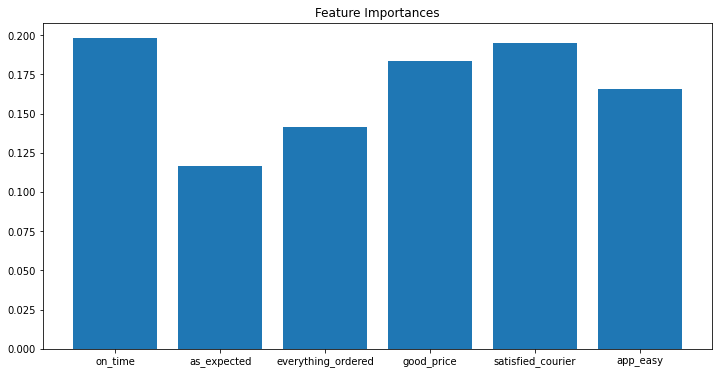

In [ ]:
feature_importances = best_rf.feature_importances_
features = X_train.columns.tolist()

# summarize feature importance
for i,v in enumerate(feature_importances):
	print('Feature: {}, Score: {}'.format(features[i],v))
 
# plot feature importance
plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(features, feature_importances)

plt.show()

The graph above shows the feature importances of each feature. This depicts how influential the feature was for the random forest to make a classification decision on a row. We can use this data to gain insight on what drives a customers decision, and if we can remove any to make the survey shorter.



## Evaluation

Below we will take a look a how each model above performs on the validation sets that were set aside from the beggining. This will show how the model's perform on data they have not seen before. 


In [ ]:
clfs = [best_gnb, best_logr, best_rf, best_svc]
classifier_labels = ['Gaussian Naive Bayes', 'Logistic Regression', 'Random Forest', 'Support Vector Classification']
test_f1_scores = []

for clf in clfs:
  y_test_preds = clf.predict(X_test)
  test_f1_score = f1_score(y_test, y_test_preds)
  test_f1_scores.append(test_f1_score)


test_df = pd.DataFrame(np.array(test_f1_scores), index=classifier_labels, columns=['F1 Score'])

test_df.head()

,F1 Score
Gaussian Naive Bayes,0.533333
Logistic Regression,0.555556
Random Forest,0.909091
Support Vector Classification,0.631579


We can visualize these results using confusion matrices to see how each model predicted each class.

A confusion matrix works by showing the true label on the Y-axis and the Predicted Label on the X-Axis. This allows us to see how many were guessed correctly per class and how many times the items were misclassified on other classes. This is especially useful if we have more than two classes to see not only how many are being misclassified, but how which class it is being misclassified as.



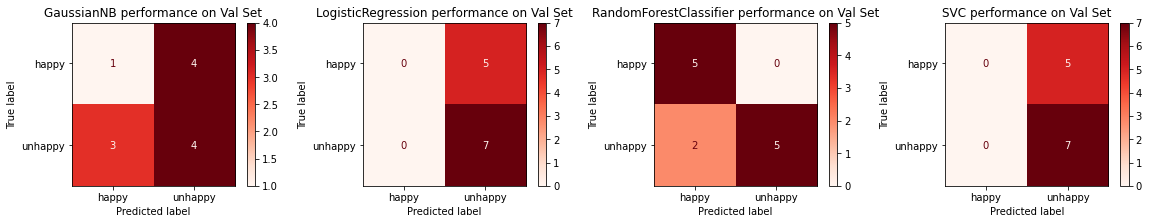

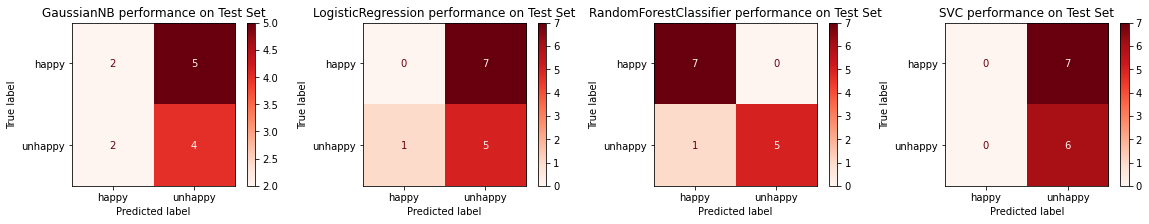

In [ ]:
# plot confusion matrices
fig, ax = plt.subplots(1, 4, figsize=(20,3))

# plot validation confusion matrices
for clf, ax in zip(clfs, ax.flatten()):
  plot_confusion_matrix(clf,
                        X_val,
                        y_val,
                        ax=ax,
                        cmap='Reds',
                        display_labels=classes)
  ax.title.set_text("{} performance on Val Set".format(type(clf).__name__))

fig2, ax2 = plt.subplots(1, 4, figsize=(20,3))

# plot test set confusion matrices
for clf, ax2 in zip(clfs, ax2.flatten()):
  plot_confusion_matrix(clf,
                      X_test,
                      y_test,
                      ax=ax2,
                      cmap='Reds',
                      display_labels=classes)
  ax2.title.set_text("{} performance on Test Set".format(type(clf).__name__))

  
plt.show()



By examining the results above we can see that the random forest classifier was the only model that was able to correctly learn from the training data. The rest of the models tend to have a bias towards guessing unhappy. This may be there being slightly more unhappy customers in the training set, and since the models were not able to learn the data, they tend to a focus on minimizing loss.

After testing on the validation set, we see that the model's did not perform exactly the same. Other than the Gaussian naive Bayes model, the logistic regressor and the SVC did worse. Although it seems like those two models just always guess unhappy, they did not learn the data and the distributions of the test vs val data changed the results.

Our real performer here is the Random Forest Classifer, being able to generalize well and only make 1 mistake by miscategorizing an unhappy customer as unhappy.

This is a good start, but let's see if we can change up the metrics by removing some features and see if there's any more optimizations we can make.

## Bonus(es):

We are very interested in finding which questions/features are more important when predicting a customer’s happiness. Using a feature selection approach show us understand what is the minimal set of attributes/features that would preserve the most information about the problem while increasing predictability of the data we have. Is there any question that we can remove in our next survey?


Looks like some features, specifically on_time and app_easy are a lot more significant than features like everything_ordered or as_expected. <br/>

Let's try removing them and see how the classifier performs.



In [ ]:
# initialize variables for data collection
modified_test_scores = []
best_modified_models = []
best_removed_feature = []

In [ ]:
top_score = 0.0
feature_removed = ""
modified_best_gnb = None

for feature in X_train.columns:
  X_train_less_features = X_train.drop(feature, axis=1)
  X_val_less_features = X_val.drop(feature, axis=1)
  
  print("Testing with Removal of {}".format(feature))
  modified_gnb, modified_best_hyperparams, best_score = GNB_grid_search(X_train_less_features, y_train, X_val_less_features, y_val, verbose=False)

  if best_score > top_score:
    top_score = best_score
    feature_removed = feature
    modified_best_gnb = modified_gnb
    X_train_working_set = X_train_less_features

print("Best Score with a removed feature: {}".format(top_score))
print("Feature Removed: {}".format(feature_removed))

y_val_preds = modified_best_gnb.predict(X_test.drop(feature_removed, axis=1))
score = f1_score(y_test, y_test_preds)

modified_test_scores.append(score)
best_modified_models.append(modified_best_gnb)
best_removed_feature.append(feature_removed)

print('Test Score {}'.format(score))

Testing with Removal of on_time
Best hyperparameters:
{'var_smoothing': 0.1}
Train Score: 0.6956521739130435
Test Score: 0.5333333333333333
Testing with Removal of as_expected
Best hyperparameters:
{'var_smoothing': 1}
Train Score: 0.7301587301587301
Test Score: 0.5333333333333333
Testing with Removal of everything_ordered
Best hyperparameters:
{'var_smoothing': 0.1}
Train Score: 0.6779661016949152
Test Score: 0.5333333333333333
Testing with Removal of good_price
Best hyperparameters:
{'var_smoothing': 1}
Train Score: 0.7142857142857142
Test Score: 0.5333333333333333
Testing with Removal of satisfied_courier
Best hyperparameters:
{'var_smoothing': 1}
Train Score: 0.7175572519083969
Test Score: 0.6250000000000001
Testing with Removal of app_easy
Best hyperparameters:
{'var_smoothing': 1}
Train Score: 0.7154471544715447
Test Score: 0.588235294117647
Best Score with a removed feature: 0.6250000000000001
Feature Removed: satisfied_courier
Test Score 0.631578947368421


In [ ]:
top_score = 0.0
feature_removed = ""
modified_best_logr = None

for feature in X_train.columns:
  X_train_less_features = X_train.drop(feature, axis=1)
  X_test_less_features = X_test.drop(feature, axis=1)
  
  print("Testing with Removal of {}".format(feature))
  modified_logr, modified_best_hyperparams, best_score = logistic_regression_grid_search(X_train_less_features, y_train, X_val_less_features, y_val, verbose=False)

  if best_score > top_score:
    top_score = best_score
    feature_removed = feature
    modified_best_logr = modified_logr
    X_train_working_set = X_train_less_features

print("Best Score with a removed feature: {}".format(top_score))
print("Feature Removed: {}".format(feature_removed))

y_test_preds = modified_logr.predict(X_test.drop(feature_removed, axis=1))
score = f1_score(y_test, y_test_preds)

modified_test_scores.append(score)
best_modified_models.append(modified_best_logr)
best_removed_feature.append(feature_removed)

print('Test Score {}'.format(score))

Testing with Removal of on_time
Best hyperparameters:
{'C': 0.01, 'class_weight': None, 'solver': 'liblinear', 'random_state': 42}
Train Score: 0.7096774193548387
Test Score: 0.7368421052631579
Testing with Removal of as_expected
Best hyperparameters:
{'C': 1.0, 'class_weight': None, 'solver': 'liblinear', 'random_state': 42}
Train Score: 0.7142857142857142
Test Score: 0.7777777777777778
Testing with Removal of everything_ordered
Best hyperparameters:
{'C': 0.1, 'class_weight': None, 'solver': 'liblinear', 'random_state': 42}
Train Score: 0.703125
Test Score: 0.7777777777777778
Testing with Removal of good_price
Best hyperparameters:
{'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear', 'random_state': 42}
Train Score: 0.7464788732394366
Test Score: 0.75
Testing with Removal of satisfied_courier
Best hyperparameters:
{'C': 0.01, 'class_weight': None, 'solver': 'liblinear', 'random_state': 42}
Train Score: 0.7051282051282052
Test Score: 0.7368421052631579
Testing with Removal o

In [ ]:
top_score = 0.0
feature_removed = ""
modified_best_rf = None

for feature in X_train.columns:
  X_train_less_features = X_train.drop(feature, axis=1)
  X_val_less_features = X_val.drop(feature, axis=1)
  
  print("Testing with Removal of {}".format(feature))
  modified_rf, modified_best_hyperparams, best_score = random_forest_grid_search(X_train_less_features, y_train, X_val_less_features, y_val, verbose=False)

  if best_score > top_score:
    top_score = best_score
    feature_removed = feature
    modified_best_rf = modified_rf
    X_train_working_set = X_train_less_features

print("Best Score with a removed feature: {}".format(top_score))
print("Feature Removed: {}".format(feature_removed))

y_test_preds = modified_best_rf.predict(X_test.drop(feature_removed, axis=1))
score = f1_score(y_test, y_test_preds)

modified_test_scores.append(score)
best_modified_models.append(modified_best_rf)
best_removed_feature.append(feature_removed)

print('Test Score {}'.format(score))

Testing with Removal of on_time
Best hyperparameters:
{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 4, 'random_state': 42}
Train Score: 0.7019867549668874
Train Score: 0.7777777777777778
Testing with Removal of as_expected
Best hyperparameters:
{'n_estimators': 10, 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 4, 'random_state': 42}
Train Score: 0.8392857142857144
Train Score: 0.7999999999999999
Testing with Removal of everything_ordered
Best hyperparameters:
{'n_estimators': 5, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'random_state': 42}
Train Score: 0.819047619047619
Train Score: 0.7999999999999999
Testing with Removal of good_price
Best hyperparameters:
{'n_estimators': 2, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 4, 'random_state': 42}
Train Score: 0.8141592920353982
Train Score: 0.7692307692307692
Testing with Removal of satisfied_courier
Best hyperparameters:
{'n_estimators': 50, 'max_depth': 

In [ ]:
top_score = 0.0
feature_removed = ""
modified_best_svc = None

for feature in X_train.columns:
  X_train_less_features = X_train.drop(feature, axis=1)
  X_val_less_features = X_val.drop(feature, axis=1)
  
  print("Testing with Removal of {}".format(feature))
  modified_svc, modified_best_hyperparams, best_score = SVC_grid_search(X_train_less_features, y_train, X_val_less_features, y_val, verbose=False)

  if best_score > top_score:
    top_score = best_score
    feature_removed = feature
    modified_best_svc = modified_svc
    X_train_working_set = X_train_less_features

print("Best Score with a removed feature: {}".format(top_score))
print("Feature Removed: {}".format(feature_removed))

y_test_preds = modified_svc.predict(X_test.drop(feature_removed, axis=1))
score = f1_score(y_test, y_test_preds)

modified_test_scores.append(score)
best_modified_models.append(modified_best_svc)
best_removed_feature.append(feature_removed)

print('Test Score {}'.format(score))

Testing with Removal of on_time
Best hyperparameters:
{'C': 10.0, 'kernel': 'sigmoid', 'random_state': 42}
Train Score: 0.7051282051282052
Test Score: 0.7368421052631579
Testing with Removal of as_expected
Best hyperparameters:
{'C': 10.0, 'kernel': 'sigmoid', 'random_state': 42}
Train Score: 0.7051282051282052
Test Score: 0.7368421052631579
Testing with Removal of everything_ordered
Best hyperparameters:
{'C': 10.0, 'kernel': 'sigmoid', 'random_state': 42}
Train Score: 0.7051282051282052
Test Score: 0.7368421052631579
Testing with Removal of good_price
Best hyperparameters:
{'C': 10.0, 'kernel': 'sigmoid', 'random_state': 42}
Train Score: 0.7051282051282052
Test Score: 0.7368421052631579
Testing with Removal of satisfied_courier
Best hyperparameters:
{'C': 10.0, 'kernel': 'sigmoid', 'random_state': 42}
Train Score: 0.7051282051282052
Test Score: 0.7368421052631579
Testing with Removal of app_easy
Best hyperparameters:
{'C': 10.0, 'kernel': 'rbf', 'random_state': 42}
Train Score: 0.846

In [ ]:
classifier_labels = ['Gaussian Naive Bayes', 'Logistic Regression', 'Random Forest', 'Support Vector Classification']
removed_features = best_removed_feature

d = {'Original F1 Scores': test_f1_scores, 'F1 Score With a Removed Feature': modified_test_scores, 'Removed Feature': removed_features}

val_df = pd.DataFrame(data=d, index=classifier_labels)

val_df.head()

,Original F1 Scores,F1 Score With a Removed Feature,Removed Feature
Gaussian Naive Bayes,0.533333,0.631579,satisfied_courier
Logistic Regression,0.555556,0.631579,as_expected
Random Forest,0.909091,0.909091,as_expected
Support Vector Classification,0.631579,0.833333,app_easy


As shown above, if we remove certain questions from the survey the models generally perform better, let's examine them with confusion matrices below.



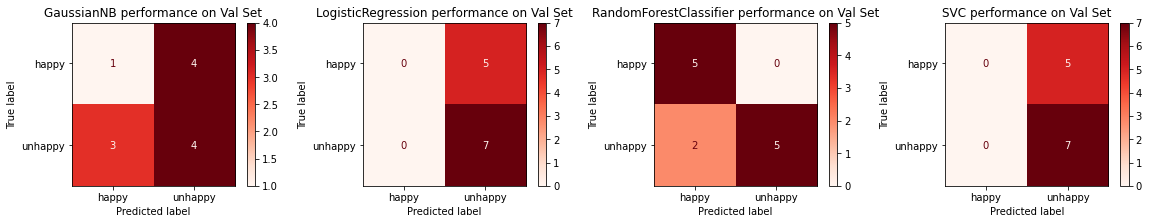

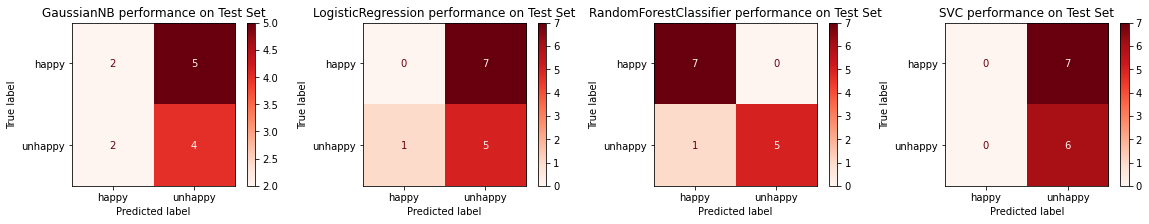

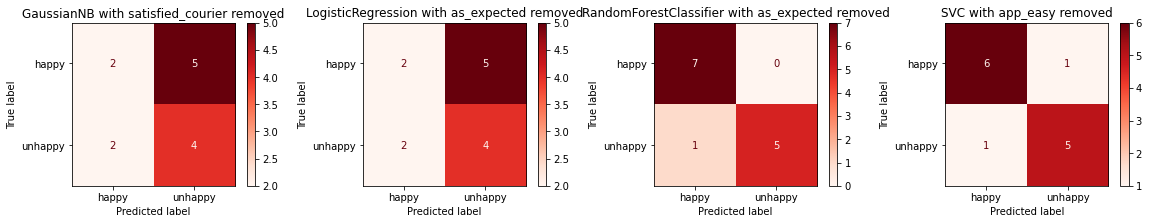

In [ ]:
# plot confusion matrices
fig, ax = plt.subplots(1, 4, figsize=(20,3))

# plot validation confusion matrices
for clf, ax in zip(clfs, ax.flatten()):
  plot_confusion_matrix(clf,
                        X_val,
                        y_val,
                        ax=ax,
                        cmap='Reds',
                        display_labels=classes)
  ax.title.set_text("{} performance on Val Set".format(type(clf).__name__))

fig2, ax2 = plt.subplots(1, 4, figsize=(20,3))

# plot test set confusion matrices
for clf, ax2 in zip(clfs, ax2.flatten()):
  plot_confusion_matrix(clf,
                      X_test,
                      y_test,
                      ax=ax2,
                      cmap='Reds',
                      display_labels=classes)
  ax2.title.set_text("{} performance on Test Set".format(type(clf).__name__))

# plot confusion matrices
fig3, ax3 = plt.subplots(1, 4, figsize=(20,3))

for clf, feature, ax3 in zip(best_modified_models, best_removed_feature, ax3.flatten()):
  plot_confusion_matrix(clf,
                        X_test.drop(feature, axis=1),
                        y_test,
                        ax=ax3,
                        cmap='Reds',
                        display_labels=classes)
  ax3.title.set_text("{} with {} removed".format(type(clf).__name__, feature))
  

plt.show()



By examining the confusion matrices, we can see that the models were generally able to learn the data better, some more than others. Aside from the equally performant random forest classifer, the SVC was able to learn the difference between happy and unhappy customers, and the logistic regression and gaussian NB are starting to learn the data.

These matrices show that we can remove some questions, based on which classifer we are using to classify the data.